<a href="https://colab.research.google.com/github/YuriiKlim/Projects/blob/Clothing_Classifier/CL_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

C:\Users\klimk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\klimk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


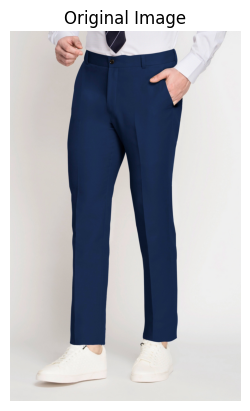


0: 1920x1184 4 persons, 1 tie, 84.5ms
Speed: 0.0ms preprocess, 84.5ms inference, 67.3ms postprocess per image at shape (1, 3, 1920, 1184)
Predicted class: Pants
Dominant colors:
Blue: 87.61%
Light-Blue: 58.02%


In [2]:
import os
import requests
from io import BytesIO
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
import cv2
from ultralytics import YOLO
from collections import Counter
from SegCloth import segment_clothing

device = "cuda" if torch.cuda.is_available() else "cpu"

class TransferLearningClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        resnet = models.resnet152(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        in_features = resnet.fc.in_features
        resnet.fc = nn.Identity()
        self.feature_extractor = resnet
        self.fc1 = nn.Linear(in_features, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.feature_extractor(x)
        out = F.relu(self.fc1(out))
        out = self.dropout1(out)
        out = F.relu(self.fc2(out))
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

class_dict = {'Dress': 0,
              'Football Boots': 1,
              'Football Sneakers': 2,
              'Full-zip Hoodie': 3,
              'Hoodie': 4,
              'Jacket': 5,
              'Leggings': 6,
              'Longsleeve': 7,
              'Pants': 8,
              'Parka': 9,
              'Polo': 10,
              'Puffer jacket': 11,
              'Shirt': 12,
              'Shorts': 13,
              'Skirt': 14,
              'Slippers': 15,
              'Sneakers': 16,
              'Sweater': 17,
              'Sweatshirt': 18,
              'T-shirt': 19,
              'Tank Top': 20,
              'Top': 21,
              'Track Jacket': 22,
              'Vest': 23}
model_load_path = 'C:/Users/klimk/Desktop/Nike/model.pth'
num_classes = len(class_dict)
model = TransferLearningClassifier(num_classes=num_classes)
model.load_state_dict(torch.load(model_load_path, map_location=device))
model.eval()


inverse_class_dict = {v: k for k, v in class_dict.items()}

class PhotoProcessing1:
    def __init__(self, yolo_model_path='yolov8n.pt', data_dir='D:/Main',
                 output_size=(800, 800), background_color='white', device='cuda'):
        self.model = YOLO(yolo_model_path)
        self.data_dir = data_dir
        self.output_size = output_size
        self.device = device
        self.background_color = background_color.lower()
        self.model.to(self.device)
        self.processed_images = {}
        self.person_class_id = self._get_person_class_id()

    def _get_person_class_id(self):
        for class_id, class_name in self.model.names.items():
            if class_name == 'person':
                return class_id
        raise ValueError("Class 'person' not found in model classes")

    def load_image(self, file_name):
        file_path = os.path.join(self.data_dir, file_name + '.jpg')
        if os.path.exists(file_path):
            image = Image.open(file_path).convert("RGB")
            return image
        else:
            return None

    def resize_for_yolo(self, image):
        width, height = image.size
        new_width = (width // 32) * 32
        new_height = (height // 32) * 32
        resized_image = image.resize((new_width, new_height))
        return resized_image

    def process_image(self, image, sku):
        image_resized = self.resize_for_yolo(image)

        output_image_rgb = np.array(image_resized)
        output_image_tensor = torch.from_numpy(output_image_rgb).permute(2, 0, 1).float() / 255.0
        output_image_tensor = output_image_tensor.unsqueeze(0).to(self.device)

        results = self.model(output_image_tensor)

        detections = results[0].boxes.data.cpu().numpy()

        person_detected = any(int(detection[5]) == self.person_class_id for detection in detections)

        if person_detected:
            processed_image = self.apply_segcloth(image_resized)
        else:
            processed_image = self.apply_background_color(image_resized)

        processed_image = processed_image.resize(self.output_size)
        self.processed_images[sku] = processed_image

    def apply_segcloth(self, image):
        result = segment_clothing(img=image)
        return result

    def apply_background_color(self, image):
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        mask = np.zeros(image_cv.shape[:2], np.uint8)
        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)
        rect = (10, 10, image_cv.shape[1] - 10, image_cv.shape[0] - 10)
        cv2.grabCut(image_cv, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        output_image = image_cv.copy()

        if self.background_color == 'white':
            output_image[mask2 == 0] = [255, 255, 255]
        elif self.background_color == 'black':
            output_image[mask2 == 0] = [0, 0, 0]
        elif self.background_color == 'transparent':
            output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2BGRA)
            output_image[mask2 == 0] = [0, 0, 0, 0]
        else:
            raise ValueError("Unsupported background color")

        output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB if self.background_color != 'transparent' else cv2.COLOR_BGRA2RGBA)
        return Image.fromarray(output_image_rgb)

    def process_images(self, skus):
        for sku in skus:
            image = self.load_image(sku)
            if image is not None:
                self.process_image(image, sku)

    def get_processed_images(self):
        return self.processed_images

class ColorAnalyzerHSV:
    def __init__(self):
        self.colors_ranges = {
            "Beige": ([20, 50, 100], [30, 150, 200]),
            "Black": ([0, 0, 0], [180, 255, 50]),
            "Blue": ([100, 150, 0], [140, 255, 255]),
            "Bordo": ([160, 100, 20], [180, 255, 255]),
            "Brown": ([10, 100, 20], [20, 255, 200]),
            "Green": ([35, 100, 20], [85, 255, 255]),
            "Grey": ([0, 0, 50], [180, 50, 200]),
            "Light-Blue": ([90, 50, 70], [110, 255, 255]),
            "Olive": ([25, 50, 50], [45, 255, 200]),
            "Orange": ([5, 100, 100], [15, 255, 255]),
            "Pink": ([140, 100, 100], [170, 255, 255]),
            "Red": ([0, 100, 100], [10, 255, 255]),
            "Turquoise": ([85, 100, 100], [100, 255, 255]),
            "Purple": ([130, 50, 50], [160, 255, 255]),
            "White": ([0, 0, 200], [180, 30, 255]),
            "Yellow": ([20, 100, 100], [30, 255, 255])
        }

    def find_dominant_colors(self, image, mask, min_area_threshold=0.15):
        image = np.array(image)
        image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        color_areas = {}
        for color_name, (lower, upper) in self.colors_ranges.items():
            lower_bound = np.array(lower, dtype="uint8")
            upper_bound = np.array(upper, dtype="uint8")
            mask_color = cv2.inRange(image_hsv, lower_bound, upper_bound)
            combined_mask = cv2.bitwise_and(mask_color, mask)
            color_area = cv2.countNonZero(combined_mask)
            total_area = cv2.countNonZero(mask)
            area_percentage = color_area / total_area
            if area_percentage > min_area_threshold:
                color_areas[color_name] = area_percentage * 100
        return color_areas

def load_and_predict(url, model, processor, transform, device='cpu'):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title("Original Image")
    plt.show()

    processor.process_image(image, sku="temp_sku")
    processed_image = processor.get_processed_images()["temp_sku"]

    image_tensor = transform(processed_image).unsqueeze(0)
    model = model.to(device)
    image_tensor = image_tensor.to(device)
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        prediction = output.argmax(dim=1).item()

    class_name = inverse_class_dict[prediction]

    image_np = np.array(processed_image)
    mask = np.zeros(image_np.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (10, 10, image_np.shape[1] - 10, image_np.shape[0] - 10)
    cv2.grabCut(image_np, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    analyzer = ColorAnalyzerHSV()
    dominant_colors = analyzer.find_dominant_colors(processed_image.convert("RGB"), mask2)

    return class_name, dominant_colors

def main():
    processor = PhotoProcessing1(background_color='white')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.8329, 0.8211, 0.8254], std=[0.2497, 0.2639, 0.2580])
    ])

    image_url = "https://cdn.hangrr.com/v7/s3/product/446/royal-blue-cotton-pants-multi.webp"
    predicted_class, dominant_colors = load_and_predict(image_url, model, processor, transform, device=device)

    print(f"Predicted class: {predicted_class}")
    if dominant_colors:
        print("Dominant colors:")
        for color_name, percentage in dominant_colors.items():
            print(f"{color_name}: {percentage:.2f}%")
    else:
        print("No dominant colors found above the threshold.")

if __name__ == "__main__":
    main()
